# Classification Model

In [1]:
import numpy as np
import pandas as pd

heart = pd.read_csv("../data/heart-disease.csv")

In [3]:
heart.isna().sum()

age         0
sex         0
cp          0
trestbps    0
chol        0
fbs         0
restecg     0
thalach     0
exang       0
oldpeak     0
slope       0
ca          0
thal        0
target      0
dtype: int64

In [6]:
heart.dtypes

age           int64
sex           int64
cp            int64
trestbps      int64
chol          int64
fbs           int64
restecg       int64
thalach       int64
exang         int64
oldpeak     float64
slope         int64
ca            int64
thal          int64
target        int64
dtype: object

In [75]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.metrics import roc_auc_score, roc_curve
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score

from sklearn.metrics import classification_report 

np.random.seed(42)

X = heart.drop("target", axis=1)
y = heart["target"]

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)

model = RandomForestClassifier(n_estimators=100, n_jobs=-1)
model.fit(X_train, y_train)

model.score(X_test, y_test)

predictions = model.predict(X_test)
predictions_probability = model.predict_proba(X_test)
fpr, tpr, thresholds = roc_curve(y_test, predictions_probability[:,1])

In [68]:
cross_val_score(model, X, y, cv=5)

array([0.83606557, 0.8852459 , 0.7704918 , 0.8       , 0.8       ])

In [88]:
'''
function to plot roc score and confusion matrix
returns metrics on predictions
'''
import matplotlib.pyplot as plt

def plot_roc_curve(fpr, tpr, proba, y_preds, y_test):
    plt.plot(fpr, tpr, color="orange", label="ROC")
    plt.plot([0,1],[0,1], color="darkblue", linestyle="--", label="Guessing")
    
    
    
    plt.xlabel("False positive rate (fpr)")
    plt.ylabel("True positive rate (tpr)")
    plt.title("Receiver Operating Characteristic (ROC) curve")
    plt.legend()
    plt.show()
    
    ConfusionMatrixDisplay.from_predictions(y_true=y_test,
                                       y_pred=y_preds)
    
    auc = roc_auc_score(y_test, proba[:,1])
    accuracy = accuracy_score(y_test, y_preds)
    precision = precision_score(y_test, y_preds)
    recall = recall_score(y_test, y_preds)
    f1 = f1_score(y_test, y_preds)
    metric_dict = {"auc": round(auc, 2),
                  "accuracy": round(accuracy, 2),
                  "precision": round(precision, 2),
                  "recall": round(recall, 2),
                  "f1": round(f1, 2)}
    
    print(f"Area Under Curve: {roc_auc_score(y_test, proba[:,1]) * 100}")
    print("Classifier metrics on the test set")
    print(f"Accuracy: {accuracy_score(y_test, y_preds)*100:2f}%")
    print(f"Precision: {precision_score(y_test, y_preds)*100:2f}")
    print(f"Recall: {recall_score(y_test, y_preds)*100:2f}")
    print(f"F1: {f1_score(y_test, y_preds)*100:2f}")
    

    print(classification_report(y_test, y_preds))
    
    return metric_dict
    

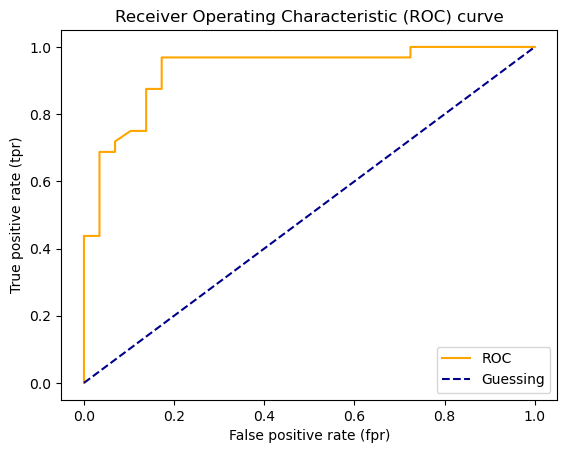

Area Under Curve: 93.04956896551724
Classifier metrics on the test set
Accuracy: 85.245902%
Precision: 84.848485
Recall: 87.500000
F1: 86.153846
              precision    recall  f1-score   support

           0       0.86      0.83      0.84        29
           1       0.85      0.88      0.86        32

    accuracy                           0.85        61
   macro avg       0.85      0.85      0.85        61
weighted avg       0.85      0.85      0.85        61



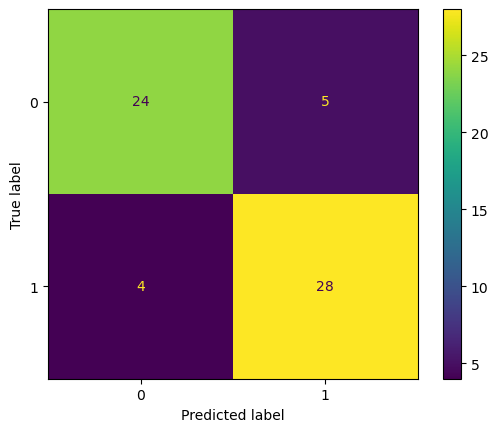

In [89]:
baseline = plot_roc_curve(fpr, tpr, predictions_probability, predictions, y_test)

## Random Search CV

Fitting 5 folds for each of 10 candidates, totalling 50 fits
[CV] END max_depth=5, max_features=sqrt, min_samples_leaf=4, min_samples_split=6, n_estimators=200; total time=   2.1s
[CV] END max_depth=5, max_features=sqrt, min_samples_leaf=4, min_samples_split=6, n_estimators=200; total time=   0.1s
[CV] END max_depth=5, max_features=sqrt, min_samples_leaf=4, min_samples_split=6, n_estimators=200; total time=   0.1s
[CV] END max_depth=5, max_features=sqrt, min_samples_leaf=4, min_samples_split=6, n_estimators=200; total time=   0.1s
[CV] END max_depth=5, max_features=sqrt, min_samples_leaf=4, min_samples_split=6, n_estimators=200; total time=   0.1s
[CV] END max_depth=10, max_features=None, min_samples_leaf=4, min_samples_split=2, n_estimators=1000; total time=   0.4s
[CV] END max_depth=10, max_features=None, min_samples_leaf=4, min_samples_split=2, n_estimators=1000; total time=   0.4s
[CV] END max_depth=10, max_features=None, min_samples_leaf=4, min_samples_split=2, n_estimators=1000; 

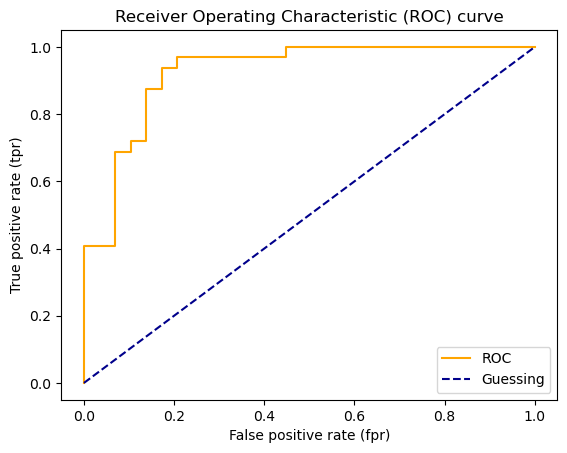

Area Under Curve: 92.45689655172413
Classifier metrics on the test set
Accuracy: 86.885246%
Precision: 85.294118
Recall: 90.625000
F1: 87.878788
              precision    recall  f1-score   support

           0       0.89      0.83      0.86        29
           1       0.85      0.91      0.88        32

    accuracy                           0.87        61
   macro avg       0.87      0.87      0.87        61
weighted avg       0.87      0.87      0.87        61



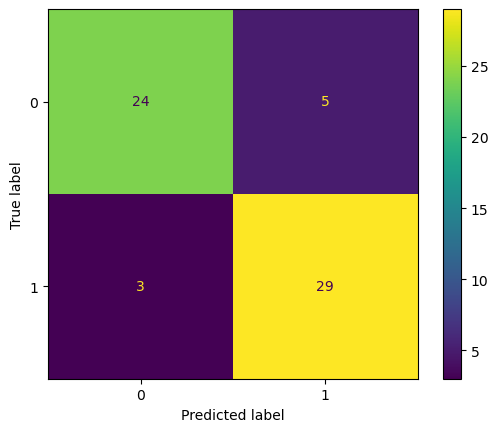

In [96]:
from sklearn.model_selection import RandomizedSearchCV

grid = {"n_estimators": [10, 100, 200, 500, 1000, 1200],
       "max_depth": [None, 5, 10, 20, 30],
       "max_features": [None, 0.5, "sqrt"],
       "min_samples_split": [2, 4, 6],
       "min_samples_leaf": [1, 2, 4]}

rs_model = RandomizedSearchCV(estimator=model,
                             param_distributions=grid,
                             n_iter=10,
                             cv=5,
                             verbose=2)

rs_model.fit(X_train, y_train)

rs_predictions = rs_model.predict(X_test)
rs_predictions_probability = rs_model.predict_proba(X_test)
rs_fpr, rs_tpr, rs_thresholds = roc_curve(y_test, rs_predictions_probability[:,1])
rs_metric = plot_roc_curve(rs_fpr, rs_tpr, rs_predictions_probability, rs_predictions, y_test)

## Grid Search CV

Fitting 5 folds for each of 24 candidates, totalling 120 fits
[CV] END max_depth=None, max_features=None, min_samples_leaf=1, min_samples_split=6, n_estimators=10; total time=   0.0s
[CV] END max_depth=None, max_features=None, min_samples_leaf=1, min_samples_split=6, n_estimators=10; total time=   0.0s
[CV] END max_depth=None, max_features=None, min_samples_leaf=1, min_samples_split=6, n_estimators=10; total time=   0.0s
[CV] END max_depth=None, max_features=None, min_samples_leaf=1, min_samples_split=6, n_estimators=10; total time=   0.0s
[CV] END max_depth=None, max_features=None, min_samples_leaf=1, min_samples_split=6, n_estimators=10; total time=   0.0s
[CV] END max_depth=None, max_features=None, min_samples_leaf=1, min_samples_split=6, n_estimators=100; total time=   0.0s
[CV] END max_depth=None, max_features=None, min_samples_leaf=1, min_samples_split=6, n_estimators=100; total time=   0.0s
[CV] END max_depth=None, max_features=None, min_samples_leaf=1, min_samples_split=6, n_es

[CV] END max_depth=None, max_features=0.5, min_samples_leaf=2, min_samples_split=6, n_estimators=100; total time=   0.0s
[CV] END max_depth=None, max_features=0.5, min_samples_leaf=2, min_samples_split=6, n_estimators=200; total time=   0.1s
[CV] END max_depth=None, max_features=0.5, min_samples_leaf=2, min_samples_split=6, n_estimators=200; total time=   0.1s
[CV] END max_depth=None, max_features=0.5, min_samples_leaf=2, min_samples_split=6, n_estimators=200; total time=   0.1s
[CV] END max_depth=None, max_features=0.5, min_samples_leaf=2, min_samples_split=6, n_estimators=200; total time=   0.1s
[CV] END max_depth=None, max_features=0.5, min_samples_leaf=2, min_samples_split=6, n_estimators=200; total time=   0.1s
[CV] END max_depth=None, max_features=0.5, min_samples_leaf=2, min_samples_split=6, n_estimators=500; total time=   0.2s
[CV] END max_depth=None, max_features=0.5, min_samples_leaf=2, min_samples_split=6, n_estimators=500; total time=   0.4s
[CV] END max_depth=None, max_fea

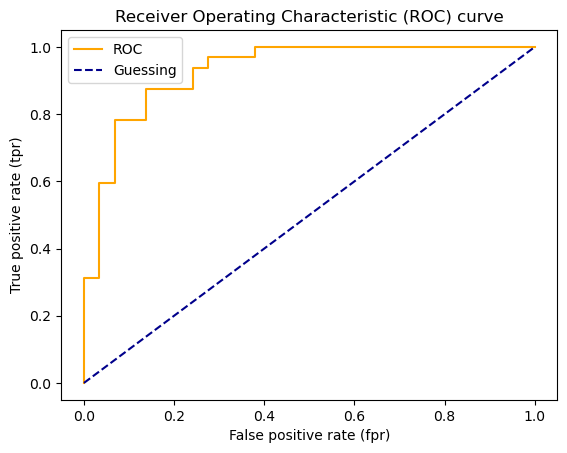

Area Under Curve: 92.88793103448276
Classifier metrics on the test set
Accuracy: 86.885246%
Precision: 87.500000
Recall: 87.500000
F1: 87.500000
              precision    recall  f1-score   support

           0       0.86      0.86      0.86        29
           1       0.88      0.88      0.88        32

    accuracy                           0.87        61
   macro avg       0.87      0.87      0.87        61
weighted avg       0.87      0.87      0.87        61



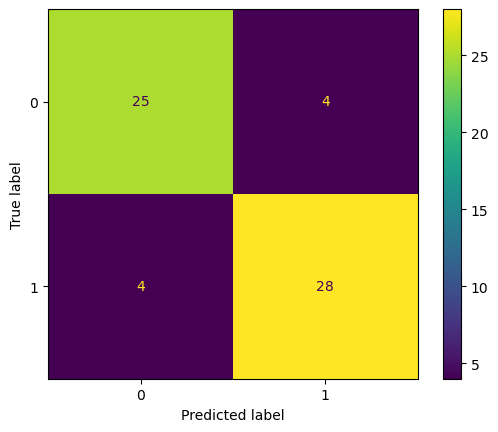

In [97]:
from sklearn.model_selection import GridSearchCV

grid_2 = {'n_estimators': [10, 100, 200, 500],
 'max_depth': [None],
 'max_features': [None, 0.5, 'sqrt'],
 'min_samples_split': [6],
 'min_samples_leaf': [1, 2]}

gs_model=GridSearchCV(estimator=model,
                           param_grid=grid_2,
                           cv=5,
                           verbose=2)

gs_model.fit(X_train, y_train)

gs_predictions = gs_model.predict(X_test)
gs_predictions_probability = gs_model.predict_proba(X_test)
gs_fpr, gs_tpr, gs_thresholds = roc_curve(y_test, gs_predictions_probability[:,1])
gs_metric = plot_roc_curve(gs_fpr, gs_tpr, gs_predictions_probability, gs_predictions, y_test)

<Axes: >

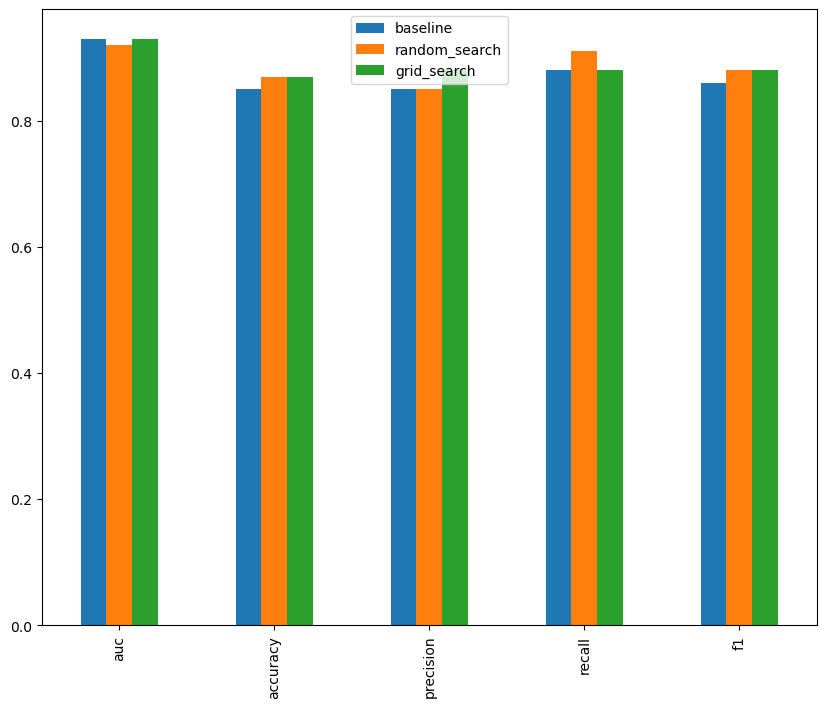

In [98]:
compare_metrics = pd.DataFrame({"baseline": baseline,
                               "random_search": rs_metric,
                               "grid_search": gs_metric})
compare_metrics.plot.bar(figsize=(10,8))